In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential, Model # Import Model here
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input # Import Input layer

# ==========================================
# 🛑 CONFIGURATION: CHOOSE YOUR PIPELINE
# ==========================================
# Set this to 'A' for your SNMP file, or 'B' for CICIDS2017
DATASET_TYPE = 'A'

# File Paths (Update these to your actual file locations)
PATH_A = 'all_data (3).csv'
PATH_B = 'Wednesday-workingHours.pcap_ISCX.csv' # Example CICIDS file

def load_and_preprocess(pipeline_type):
    print(f"--- RUNNING PIPELINE {pipeline_type} ---")

    if pipeline_type == 'A':
        # --- PIPELINE A: SNMP DATA ---
        df = pd.read_csv('/content/all_data (3).csv')

        # 1. Target Column Name
        target_col = 'class'

        # 2. Basic Cleaning (SNMP is usually clean)
        df = df.dropna()

    elif pipeline_type == 'B':
        # --- PIPELINE B: CICIDS2017 ---
        df = pd.read_csv('/content/Wednesday-workingHours.pcap_ISCX.csv.zip')

        # 1. Target Column Name
        target_col = ' Label' # Note the space in CICIDS column name

        # 2. Heavy Cleaning (Required for CICIDS)
        # Fix column names with spaces
        df.columns = df.columns.str.strip()
        target_col = 'Label'

        # Remove Infinity and NaNs (Crucial for CICIDS)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

    # --- SHARED PREPROCESSING (Common to both) ---

    # 1. Separate X (Features) and y (Labels)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # 2. Encode Labels (Text -> Numbers)
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    # 3. Scale Features (0 to 1)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 4. Reshape for LSTM (Samples, TimeSteps, Features)
    # We use 1 timestep for static CSV rows
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    return X_reshaped, y_enc, le

# ==========================================
# 1. LOAD DATA
# ==========================================
X, y, label_encoder = load_and_preprocess(DATASET_TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Loaded. Feature Count: {X_train.shape[2]}")
print(f"Classes found: {label_encoder.classes_}")

# ==========================================
# 2. LSTM MODEL (Feature Extractor)
# ==========================================
print("\n--- TRAINING LSTM ---")

# Refactor to Functional API to explicitly define input and ensure model.input is accessible
input_tensor = Input(shape=(1, X_train.shape[2]))
x = LSTM(64, return_sequences=True)(input_tensor)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=False)(x)
x = Dropout(0.2)(x)
feature_layer_output = Dense(32, activation='relu', name='feature_layer')(x)
output_tensor = Dense(len(np.unique(y)), activation='softmax')(feature_layer_output)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# ==========================================
# 3. HYBRID STEP: EXTRACT FEATURES
# ==========================================
# The model is already built with the Functional API, so model.input is defined.
# The explicit model.build() is no longer needed.

# We create a mini-model that stops at the 'feature_layer'
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('feature_layer').output)

# Extract "Deep Features" meant for KNN
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# ==========================================
# 4. KNN MODEL (Classifier)
# ==========================================
print("\n--- TRAINING KNN ON LSTM FEATURES ---")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, y_train)

# Predict
y_pred = knn.predict(X_test_features)

# ==========================================
# 5. RESULTS
# ==========================================
acc = accuracy_score(y_test, y_pred)
print(f"\nFINAL ACCURACY ({DATASET_TYPE}): {acc * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

--- RUNNING PIPELINE A ---
Data Loaded. Feature Count: 34
Classes found: ['bruteForce' 'httpFlood' 'icmp-echo' 'normal' 'slowloris' 'slowpost'
 'tcp-syn' 'udp-flood']

--- TRAINING LSTM ---
Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1743 - loss: 2.0492 - val_accuracy: 0.1750 - val_loss: 1.8996
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2581 - loss: 1.7899 - val_accuracy: 0.5125 - val_loss: 1.4126
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4963 - loss: 1.3617 - val_accuracy: 0.5375 - val_loss: 1.0013
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5742 - loss: 1.0247 - val_accuracy: 0.6675 - val_loss: 0.7640
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6927 - loss: 0.7917 - val_accuracy: 0.8300 - val_loss: 0.5962
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- TRAINING KNN ON LSTM FEATURES ---

FINAL ACCURACY (A): 100.00%
Classification Report:
            


 STARTING PIPELINE B...
Loading CICIDS2017 files (Tuesday + Wednesday)...
 Balancing Dataset (Downsampling BENIGN)...
   Original Benign Count: 871496
   Original Attack Count: 265555
 Balanced Total Rows: 531110
preprocessing data...

Training Data Shape: (424888, 1, 78)
Testing Data Shape: (106222, 1, 78)
Number of Features: 78
Classes: ['BENIGN' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest' 'DoS slowloris'
 'FTP-Patator' 'Heartbleed' 'SSH-Patator']

 Building LSTM Model...

 Training LSTM (This may take a minute)...
Epoch 1/5
5975/5975 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.8914 - loss: 0.3328 - val_accuracy: 0.9630 - val_loss: 0.0875
Epoch 2/5
5975/5975 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9679 - loss: 0.0875 - val_accuracy: 0.9828 - val_loss: 0.0491
Epoch 3/5
5975/5975 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9809 - loss: 0.0574 - val_accuracy: 0.9910 - val_loss: 0.0357
Epoch 4/5
5975/5975 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9865 - loss: 0.0

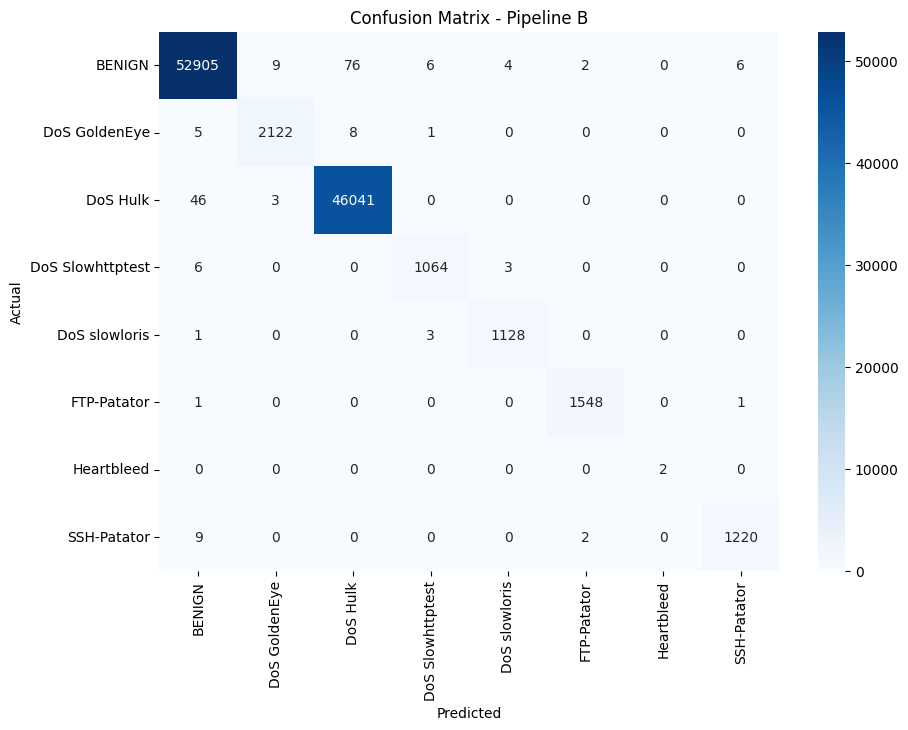

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

DATASET_TYPE = 'B'

FILE_PATH_A = 'all_data (3).csv'
FILE_PATH_B_TUE = 'Tuesday-WorkingHours.pcap_ISCX.csv'
FILE_PATH_B_WED = 'Wednesday-workingHours.pcap_ISCX.csv'

# ==========================================
# 1. DATA LOADING & BALANCING FUNCTION
# ==========================================
def load_and_process_data(pipeline_type):
    print(f"\n STARTING PIPELINE {pipeline_type}...")

    if pipeline_type == 'A':
        # --- PIPELINE A: YOUR SNMP DATA ---
        print(f"Loading {'/content/all_data (3).csv'}...")
        df = pd.read_csv('/content/all_data (3).csv')

        target_col = 'class'
        # Basic cleanup
        df.dropna(inplace=True)

    elif pipeline_type == 'B':
        # --- PIPELINE B: CICIDS2017 (WITH BALANCING) ---
        print("Loading CICIDS2017 files (Tuesday + Wednesday)...")
        try:
            df_tue = pd.read_csv('/content/Tuesday-WorkingHours.pcap_ISCX.csv.zip')
            df_wed = pd.read_csv('/content/Wednesday-workingHours.pcap_ISCX.csv.zip')
        except FileNotFoundError:
            print(" ERROR: CICIDS files not found. Please download them first.")
            return None, None, None

        # Merge
        df = pd.concat([df_tue, df_wed], axis=0)

        # Cleanup
        df.columns = df.columns.str.strip() # Remove spaces in column names
        target_col = 'Label'

        # Remove Infinity/NaN (Critical for CICIDS)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

        # --- THE BALANCING LOGIC (DOWNSAMPLING) ---
        print(" Balancing Dataset (Downsampling BENIGN)...")
        df_benign = df[df[target_col] == 'BENIGN']
        df_attacks = df[df[target_col] != 'BENIGN']

        print(f"   Original Benign Count: {len(df_benign)}")
        print(f"   Original Attack Count: {len(df_attacks)}")

        # Sample Benign to match Attack count (1:1 Ratio)
        df_benign_downsampled = resample(df_benign,
                                         replace=False,
                                         n_samples=len(df_attacks),
                                         random_state=42)

        # Combine
        df = pd.concat([df_benign_downsampled, df_attacks])
        # Shuffle
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        print(f" Balanced Total Rows: {len(df)}")


    # --- SHARED PREPROCESSING ---
    print("preprocessing data...")
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode Labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Scale Features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Reshape for LSTM (Samples, 1, Features)
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    return X_reshaped, y_encoded, le

# 2. MAIN EXECUTION
# A. Load Data
X, y, label_encoder = load_and_process_data(DATASET_TYPE)

if X is not None:
    # B. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\nTraining Data Shape: {X_train.shape}")
    print(f"Testing Data Shape: {X_test.shape}")
    print(f"Number of Features: {X_train.shape[2]}")
    print(f"Classes: {label_encoder.classes_}")

    # C. Build LSTM Model (Refactored to Functional API)
    print("\n Building LSTM Model...")
    input_tensor = Input(shape=(1, X_train.shape[2]))
    x = LSTM(64, return_sequences=True)(input_tensor)
    x = Dropout(0.2)(x)
    x = LSTM(32, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    feature_layer_output = Dense(32, activation='relu', name='feature_layer')(x)
    output_tensor = Dense(len(label_encoder.classes_), activation='softmax')(feature_layer_output)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # D. Train LSTM
    print("\n Training LSTM (This may take a minute)...")
    history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

    # E. Hybrid Feature Extraction (LSTM -> KNN)
    print("\n Extracting Deep Features for KNN...")
    # model.input is now reliably defined because of the Functional API approach.
    feature_extractor = Model(inputs=model.input, outputs=model.get_layer('feature_layer').output)
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    # F. Train KNN
    print("\n Training KNN Classifier...")
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_features, y_train)

    # G. Evaluate
    print("\n Evaluating Final Results...")
    y_pred = knn.predict(X_test_features)
    acc = accuracy_score(y_test, y_pred)

    print("="*40)
    print(f"FINAL ACCURACY ({DATASET_TYPE}): {acc * 100:.2f}%")
    print("="*40)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # H. Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - Pipeline {DATASET_TYPE}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()